# Writing ISD data to partitioned parquet

You'll need to download a year of ISD data, e.g. from Microsoft's Planetary Computer.
We're using https://github.com/gadomski/pyisd to read the data.

In [2]:
import dask
from dask.distributed import Client
import dask.dataframe
import dask_geopandas
import pandas
import os
import isd
import isd.pandas

client = Client("tcp://192.168.240.145:8786")

def read_to_data_frame(path):
    with isd.open(path) as iterator:
        records = list(iterator)
    data_frame = isd.pandas.data_frame(records)
    timestamp = pandas.to_datetime(data_frame[["year", "month", "day", "hour", "minute"]])
    data_frame["timestamp"] = timestamp
    data_frame.set_index("timestamp")
    return data_frame

data_frames = []
for file_name in os.listdir("isd/2020"):
    path = os.path.join("isd/2020", file_name)
    data_frames.append(dask.delayed(read_to_data_frame)(path))

data_frame = dask.dataframe.from_delayed(data_frames)
geo_data_frame = dask_geopandas.from_dask_dataframe(data_frame)
geo_data_frame = geo_data_frame.set_geometry(
    dask_geopandas.points_from_xy(data_frame, "longitude", "latitude")
)
geo_data_frame = geo_data_frame.persist()
geo_data_frame = geo_data_frame.set_index("timestamp")
geo_data_frame = geo_data_frame.repartition(freq="1w")
geo_data_frame.to_parquet("isd/parquet-full-weekly", overwrite=True)

KeyboardInterrupt: 

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [19]:
data_frame = dask_geopandas.read_parquet("isd/parquet")
data_frame.groupby(["usaf_id", "ncei_id"])[["latitude", "longitude", "air_temperature"]].mean().compute()

/Users/gadomski/.virtualenvs/chalkboard/lib/python3.9/site-packages/dask_geopandas/core.py:23: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  output.crs = results[0].crs


,,latitude,longitude,air_temperature
usaf_id,ncei_id,,,
067000,99999,46.241885,6.116719,12.166905
067150,99999,46.183000,7.032111,12.006594
165990,99999,35.850000,14.500000,19.810530
266661,99999,53.601574,24.053147,9.339626
478540,99999,32.084000,131.451000,18.633659
606720,99999,24.217000,5.533000,23.775822
720334,93764,39.167020,-77.166980,14.028670
725105,14770,40.821000,-76.864000,11.247276
726419,94929,46.549000,-90.919000,5.862026


<AxesSubplot:xlabel='timestamp'>

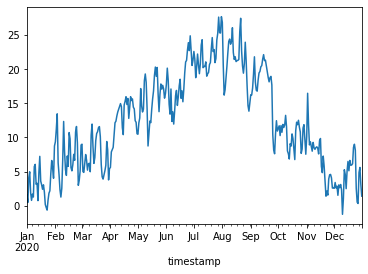

In [20]:
data_frame[data_frame.usaf_id == "067000"]["air_temperature"].resample("24h").mean().compute().plot()